<a href="https://colab.research.google.com/github/allnes/pcam_train/blob/master/pcam_cnn_resnet_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%pip install keras-metrics

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd  '/content/drive/My Drive/DL_PCAM'

/content/drive/My Drive/DL_PCAM


In [3]:
import gzip
import shutil
import pandas as pd
from matplotlib import pyplot
import numpy as np
import cv2 as cv
from keras.utils import HDF5Matrix, normalize
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, BatchNormalization, Dropout, Activation, Input, ZeroPadding2D, Add
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import keras_metrics as ksm
import tensorflow as tf

Using TensorFlow backend.


In [4]:
%ls

camelyonpatch_level_2_split_test_meta.csv
camelyonpatch_level_2_split_test_x.h5
camelyonpatch_level_2_split_test_x.h5.gz
camelyonpatch_level_2_split_test_y.h5
camelyonpatch_level_2_split_test_y.h5.gz
camelyonpatch_level_2_split_train_meta.csv
camelyonpatch_level_2_split_train_x.h5
camelyonpatch_level_2_split_train_x.h5.gz
camelyonpatch_level_2_split_train_y.h5
camelyonpatch_level_2_split_train_y.h5.gz
camelyonpatch_level_2_split_valid_meta.csv
camelyonpatch_level_2_split_valid_x.h5
camelyonpatch_level_2_split_valid_x.h5.gz
camelyonpatch_level_2_split_valid_y.h5
camelyonpatch_level_2_split_valid_y.h5.gz
model.png
__pycache__/


In [0]:
def uzip_file(file_name, origin_name):
  with gzip.open(file_name, 'rb') as f_in:
      with open(origin_name, 'wb') as f_out:
          shutil.copyfileobj(f_in, f_out)

# uzip_file(train_x_name + '.gz', train_x_name)
# uzip_file(train_y_name + '.gz', train_y_name)

# uzip_file(test_x_name + '.gz', test_x_name)
# uzip_file(test_y_name + '.gz', test_y_name)

# uzip_file(valid_x_name + '.gz', valid_x_name)
# uzip_file(valid_y_name + '.gz', valid_y_name)

In [0]:
train_x_name = 'camelyonpatch_level_2_split_train_x.h5'
train_y_name = 'camelyonpatch_level_2_split_train_y.h5'

test_x_name = 'camelyonpatch_level_2_split_test_x.h5'
test_y_name = 'camelyonpatch_level_2_split_test_y.h5'

valid_x_name = 'camelyonpatch_level_2_split_valid_x.h5'
valid_y_name = 'camelyonpatch_level_2_split_valid_y.h5'

meta_train_name = 'camelyonpatch_level_2_split_train_meta.csv'
meta_valid_name = 'camelyonpatch_level_2_split_valid_meta.csv'
meta_test_name  = 'camelyonpatch_level_2_split_test_meta.csv'

In [0]:
x_train = HDF5Matrix(train_x_name, 'x', start = 100000, end = 200000)
y_train = HDF5Matrix(train_y_name, 'y', start = 100000, end = 200000)

x_valid = HDF5Matrix(valid_x_name, 'x')
y_valid = HDF5Matrix(valid_y_name, 'y')

x_test = HDF5Matrix(test_x_name, 'x')
y_test = HDF5Matrix(test_y_name, 'y')

meta_train = pd.read_csv(meta_train_name)
meta_valid = pd.read_csv(meta_valid_name)
meta_test  = pd.read_csv(meta_test_name)

100000
<class 'keras.utils.io_utils.HDF5Matrix'>
<class 'numpy.ndarray'>
(96, 96, 3)


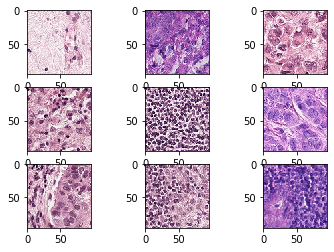

In [8]:
print(len(x_train))
print(type(x_train))
print(type(x_train[0]))
print(x_train[0].shape)

for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()


In [0]:
current_core = 64
full_size = current_core * current_core * 3
original_shape = (96, 96, 3)
new_shape = (current_core, current_core, 3)
new_size = (current_core, current_core)


def resize_for_train(x_array, x_shape):
    return np.array([cv.resize(elem, dsize=x_shape) for elem in x_array])
x_train = resize_for_train(x_train, new_size)
x_valid = resize_for_train(x_valid, new_size)
x_test  = resize_for_train(x_test,  new_size)

In [0]:
def plot_metrics(code_metrics, name_metrics):
    pyplot.plot(history.history[code_metrics])
    pyplot.plot(history.history['val_' + code_metrics])
    pyplot.title('Model ' + name_metrics)
    pyplot.ylabel(name_metrics)
    pyplot.xlabel('Epoch')
    pyplot.legend(['Train', 'Test'], loc='upper left')
    pyplot.show()

def show_metrics(list_metrics, name_stage, name_model):
    name_metrics = ['accuracy', 'precision', 'recall', 'f1-score']
    for i in range(4):
        print(name_model + ' ' + name_stage + ' ' + 
              name_metrics[i] + ' : ' + str(list_metrics[i + 1] * 100))

In [0]:
def residual_block(X, f, filters, stage, block, s=2, convolution_block = False):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1, 1), 
                padding = 'valid', name = conv_name_base + '2a', 
                kernel_initializer = 'glorot_uniform')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), 
            padding = 'same', name = conv_name_base + '2b', 
            kernel_initializer = 'glorot_uniform')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), 
        padding = 'valid', name = conv_name_base + '2c', 
        kernel_initializer = 'glorot_uniform')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    if convolution_block:
        X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), 
                            strides = (1, 1), padding = 'valid', 
                            name = conv_name_base + '1', 
                            kernel_initializer = 'glorot_uniform'
                            )(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3, 
                                        name = bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X  

def ResNet50(input_shape = (32, 32, 3), classes = 1):
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)


    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = 'glorot_uniform')(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = residual_block(X, f = 3, filters = [64, 64, 256], stage = 2, 
                       block='a', s = 1, convolution_block = True)
    # X = residual_block(X, 3, [64, 64, 256], stage=2, block='b')
    # X = residual_block(X, 3, [64, 64, 256], stage=2, block='c')

    # # Stage 3
    # X = residual_block(X, f=3, filters=[128, 128, 512], stage = 3, 
    #                    block = 'a', s = 2, convolution_block = True)
    # X = residual_block(X, 3, [128, 128, 512], stage=3, block='b')
    # X = residual_block(X, 3, [128, 128, 512], stage=3, block='c')
    # X = residual_block(X, 3, [128, 128, 512], stage=3, block='d')

    # # Stage 4
    # X = residual_block(X, f=3, filters=[256, 256, 1024], stage = 4, 
    #                    block = 'a', s = 2, convolution_block = True)
    # X = residual_block(X, 3, [256, 256, 1024], stage=4, block='b')
    # X = residual_block(X, 3, [256, 256, 1024], stage=4, block='c')
    # X = residual_block(X, 3, [256, 256, 1024], stage=4, block='d')
    # X = residual_block(X, 3, [256, 256, 1024], stage=4, block='e')
    # X = residual_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # # Stage 5
    # X = residual_block(X, f=3, filters=[512, 512, 2048], stage = 5, 
    #                    block = 'a', s = 2, convolution_block = True)
    # X = residual_block(X, 3, [512, 512, 2048], stage=5, block='b')
    # X = residual_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', name='fc' + str(classes), kernel_initializer = 'glorot_uniform')(X)

    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [0]:
name_model = 'resnet'
model = ResNet50(new_shape)
model.summary()
sgd = optimizers.SGD(lr=0.00001, 
                     decay=1e-6, 
                     momentum=0.9, 
                     nesterov=True
                     )
model.compile(loss='binary_crossentropy', optimizer=sgd, 
              metrics = ['binary_accuracy', 
                         ksm.binary_precision(), 
                         ksm.binary_recall(),
                         ksm.binary_f1_score()
                        ]
             )

y_train = np.array(y_train)
y_train = y_train.reshape((y_train.shape[0], 1))

y_valid = np.array(y_valid)
y_valid = y_valid.reshape((y_valid.shape[0], 1))

y_test = np.array(y_test)
y_test = y_test.reshape((y_test.shape[0], 1))

datagen = ImageDataGenerator(
								preprocessing_function=lambda x: x/255.,
								width_shift_range=2,   # randomly shift images horizontally
								height_shift_range=2,  # randomly shift images vertically 
								horizontal_flip=True,  # randomly flip images
								vertical_flip=True,		 # randomly flip images
							)    

preproc = ImageDataGenerator(preprocessing_function=lambda x: x/255.)    

batch_size = 1
history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=3, 
    shuffle='batch', 
    use_multiprocessing=True,
    validation_data=preproc.flow(x_valid, y_valid, batch_size=batch_size)
    )

plot_metrics('loss', 'Loss')
plot_metrics('binary_accuracy',  'Accuracy')

show_metrics(model.evaluate(preproc.flow(x_train, y_train)), 'train', name_model)
show_metrics(model.evaluate(preproc.flow(x_valid, y_valid)), 'valid', name_model)
show_metrics(model.evaluate(preproc.flow(x_test,  y_test)),  'test',  name_model)














Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
______________________________________________________________________________